In [1]:
import gym

import random
import numpy as np

from collections import deque
print("Gym:", gym.__version__)
import matplotlib.pyplot as plt

Gym: 0.17.3


In [2]:
from unn import nn_arch,relu,relu_backward,single_layer_forward_propagation,full_forward_propagation,u_full_backward_propagation,single_layer_backward_propagation
from vnn import init_layers
from Adam import initialize_adam,update_parameters_with_adam
from baseline import b_full_backward_propagation,update_b

In [3]:
env_name = "Pendulum-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(-8.0, 8.0, (3,), float32)
Action space: Box(-2.0, 2.0, (1,), float32)


In [4]:
env.observation_space.sample()

array([-0.25991607,  0.2705232 ,  3.541339  ], dtype=float32)

In [5]:
env.action_space.sample()

array([-1.4619938], dtype=float32)

In [6]:
#Hyperparameters
NUM_EPISODES = 1000
learning_rate = 0.001
GAMMA = 0.99

In [7]:
nn_architecture=nn_arch()

In [8]:
u_params_values=init_layers(nn_architecture,seed=99)
v_params_values=init_layers(nn_architecture,seed=99)

In [9]:
state=env.reset()
state=state.reshape(3,1)

In [10]:
def policy(state,w1,w2):
    
    u,c1 = full_forward_propagation(state, u_params_values, nn_architecture)

    
    v,c2= full_forward_propagation(state,v_params_values,nn_architecture)
    
    
    a=np.random.normal(np.squeeze(u),np.squeeze(v))
    #print(a)
    return a,v,u,c1,c2

In [11]:
def gradients(a,v,u,u_params_values,v_params_values,nn_architecture,c1,c2):
    
    v_grads= v_full_backward_propagation(v, a,u, c2, v_params_values, nn_architecture)
    u_grads= u_full_backward_propagation(u, a, v,c1, u_params_values, nn_architecture)
    #print(v_grads)
    #print(u_grads)
    return v_grads,u_grads

In [12]:
a,v,u,c1,c2=policy(state,u_params_values,v_params_values)

In [13]:
u_grads= u_full_backward_propagation(u, a, v,c1, u_params_values, nn_architecture)



In [14]:
state=env.reset()
state=state.reshape(3,1)
#b_params_values=init_layers(nn_architecture,seed=99)
env.reset()
_,reward,_,_ = env.step([2])
#b,c3=full_forward_propagation(state,b_params_values,nn_architecture)
#b_grads=b_full_backward_propagation(b,reward,c3, b_params_values, nn_architecture)

In [15]:
delta_sum={}
for key in u_grads:
    delta_sum[key]=np.zeros((u_grads[key].shape))

In [16]:
''' 
b_params_values=init_layers(nn_architecture,seed=99)
env.reset()
state,reward,_,_ = env.step([2])
state=state.reshape(3,1)
b,c3=full_forward_propagation(state,b_params_values,nn_architecture)
b_grads=b_full_backward_propagation(b,reward,c3, b_params_values, nn_architecture)
b_delta_sum={}
for key in b_grads:
    b_delta_sum[key]=np.zeros((b_grads[key].shape))
    '''

In [17]:
#b,c3=full_forward_propagation(state,b_params_values,nn_architecture)



In [21]:
def initilization_RMS(params):
    s = {}
    for i in range(len(params)//2 ):
        s["dW" + str(i+1)] = np.zeros(params["W" + str(i+1)].shape)
        s["db" + str(i+1)] = np.zeros(params["b" + str(i+1)].shape)
    return s

def update_params_with_RMS(params, grads,s, beta, learning_rate):
    
    # grads has the dw and db parameters from backprop
    # params  has the W and b parameters which we have to update 
    for l in range(len(params) // 2 ):
        # HERE WE COMPUTING THE VELOCITIES 
        s["dW" + str(l+1)]= beta * s["dW" + str(l+1)] + (1 - beta) * np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta * s["db" + str(l+1)] + (1 - beta) * np.square(grads['db' + str(l+1)])
        
        #updating parameters W and b
        params["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads['dW' + str(l+1)] / (np.sqrt( s["dW" + str(l+1)] )+ pow(10,-4))
        params["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads['db' + str(l+1)] / (np.sqrt( s["db" + str(l+1)]) + pow(10,-4))

    return params

In [22]:
def update(params_values, nn_architecture, learning_rate,rewards,GAMMA,u_delta_sum):
    for layer_idx, layer in enumerate(nn_architecture):
            params_values["W" + str(layer_idx+1)] += learning_rate *u_delta_sum['dW'+str(layer_idx+1)] * sum([  r*(GAMMA**t) for t,r in enumerate(rewards)])
            params_values["b" + str(layer_idx+1)] += learning_rate * u_delta_sum['db'+str(layer_idx+1)]* sum([  r*(GAMMA**t) for t,r in enumerate(rewards)])
        
    #print(params_values)
    return params_values

In [23]:
'''
b_nn_architecture = [
    {"input_dim": 3, "output_dim": 5, "activation": "relu"},
    {"input_dim": 5, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 3, "activation": "relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"},]
    '''

In [24]:
#b_params=init_layers(b_nn_architecture)

In [26]:
#b,c4=full_forward_propagation(state, b_params, b_nn_architecture)

In [31]:
## guassisan policy 
NUM_EPISODES = 1000
learning_rate = 0.01
GAMMA = 0.99
#weight update interval
weight_update_interval=10
weights_dict={}
for i in u_params_values:
    weights_dict[i]=np.zeros((u_params_values[i].shape))
u_params_values_avg=[]    
#u_params_values_avg=0
#v_params_values_avg=0
# Keep stats for final print of graph
episode_rewards = []
num_eps=[]
#neural network architecture
nn_architecture=nn_arch()
#initailse
u_params_values=init_layers(nn_architecture,seed=99)
b_params_values=init_layers(b_nn_architecture,seed=99)
#v_params_values=init_layers(nn_architecture,seed=99)
# Our policy that maps state to action parameterized by w1,w2

def policy(state,w1):
    
    u,c1 = full_forward_propagation(state, w1, nn_architecture)

    
    #v,c2= full_forward_propagation(state,v_params_values,nn_architecture)
    v=0.0009
    
    a=np.average(u)+0.7*(v)
    a=[a]
    #print(a)
    a=np.clip(a,-2,+2)
    return a,v,u,c1

u_delta_sum={}
#v_delta_sum={}
#for key in v_grads:
    #v_delta_sum[key]=np.zeros((v_grads[key].shape))
for key in u_grads:
    u_delta_sum[key]=np.zeros((u_grads[key].shape))
    
# Main loop 
#v1,s1 = initilization_Adam(u_params_values)
#print(v)
s1=initilization_RMS(u_params_values)
s2=initilization_RMS(b_params_values)
for e in range(1,NUM_EPISODES+1):

    state = env.reset()
    ##b_grads1=[]
    grads1 = []
    grads2=[]
    rewards = []
    u_delta_sum={}
    for key in u_grads:
        u_delta_sum[key]=np.zeros((u_grads[key].shape))
    for key in b_grads:
        b_delta_sum[key]=np.zeros((b_grads[key].shape))
    # Keep track of game score to print
    score = 0
    #v,s=initialize_adam(u_params_values)
    t=0
    while True:
        
        state=state.reshape(3,1)
        state=state/env.observation_space.high
        a,v,u,c1=policy(state,u_params_values)
        #b,c3=full_forward_propagation(state,b_params_values,b_nn_architecture)
        next_state,reward,done,_ = env.step(a)
        # Compute gradient 
        
        u_grads= u_full_backward_propagation(u, a, v,c1, u_params_values, nn_architecture)
        u_params_values=update_params_with_RMS(u_params_values, u_grads,s1, beta=0.9, learning_rate=learning_rate)
        #b_grads=b_full_backward_propagation(b,reward,c3, b_params_values, b_nn_architecture)
        #b_params_values=update_params_with_RMS(b_params_values, b_grads,s2, beta=0.9, learning_rate=learning_rate)
        grads1.append(u_grads)
        ##b_grads1.append(b_grads)
        #print(b)
        rewards.append(reward)
        
        score+=reward
        state = next_state
        if done:
             break
    
    for i in grads1:
        for j in u_grads:
            u_delta_sum[j]+=i[j]
    ##for i in b_grads1:
    ##    for j in b_grads:
    ##        b_delta_sum[j]+=i[j]
    ##b_params_values=update_b(b_params_values, b_delta_sum, nn_architecture, learning_rate)
    u_params_values_avg.append(update(u_params_values, nn_architecture, learning_rate,rewards,GAMMA,u_delta_sum))
    if(e%weight_update_interval==0):
        for i in u_params_values_avg:
            for j in u_params_values:
                weights_dict[j]+=i[j]
                
        for i in weights_dict:
            weights_dict[i]=weights_dict[i]/weight_update_interval
            u_params_values[i]=weights_dict[i]
            
        for i in weights_dict:
            weights_dict[i]=np.zeros((u_params_values[i].shape))
        u_params_values_avg=[]
                
     
    episode_rewards.append(score)  #rewards 
    num_eps.append(e) #number of episodes

In [32]:
num_eps=np.squeeze(num_eps)
num_eps=num_eps[:,None]
episode_rewards=np.squeeze(episode_rewards)
episode_rewards=episode_rewards[:,None]

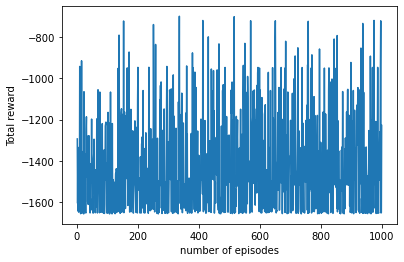

In [33]:
#plotting rewards vs episodes
plt.xlabel('number of episodes')
plt.ylabel('Total reward')
plt.plot(num_eps,episode_rewards)

In [19]:
#nn_architecture = [
   # {"input_dim": 3, "output_dim": 4, "activation": "relu"},
   # {"input_dim": 4, "output_dim": 6, "activation": "relu"},
   # {"input_dim": 6, "output_dim": 6, "activation": "relu"},
   # {"input_dim": 6, "output_dim": 4, "activation": "relu"},
   # {"input_dim": 4, "output_dim": 1, "activation": "relu"},
    #]

In [ ]:
##Beta policy - only half implemented 
NUM_EPISODES = 1000
learning_rate = 0.01
GAMMA = 0.99
#weight update interval
weight_update_interval=10
weights_dict={}
for i in u_params_values:
    weights_dict[i]=np.zeros((u_params_values[i].shape))
u_params_values_avg=[]    
#u_params_values_avg=0
#v_params_values_avg=0
# Keep stats for final print of graph
episode_rewards = []
num_eps=[]
#neural network architecture
nn_architecture=nn_arch()
#initailse
u_params_values=init_layers(nn_architecture,seed=99)
#b_params_values=init_layers(b_nn_architecture,seed=99)
v_params_values=init_layers(nn_architecture,seed=99)
# Our policy that maps state to action parameterized by w1,w2

def policy(state,w1):
    
    u,c1 = full_forward_propagation(state, w1, nn_architecture)

    
    v,c2= full_forward_propagation(state,v_params_values,nn_architecture)
    v=0.0009
    
    a=np.random.beta(u, v, size=None)
    #print(a)
    a=np.clip(a,-2,+2)
    return a,v,u,c1

u_delta_sum={}
#v_delta_sum={}
#for key in v_grads:
    #v_delta_sum[key]=np.zeros((v_grads[key].shape))
for key in u_grads:
    u_delta_sum[key]=np.zeros((u_grads[key].shape))
    
# Main loop 
#v1,s1 = initilization_Adam(u_params_values)
#print(v)
s1=initilization_RMS(u_params_values)
s2=initilization_RMS(b_params_values)
for e in range(1,NUM_EPISODES+1):

    state = env.reset()
    ##b_grads1=[]
    grads1 = []
    grads2=[]
    rewards = []
    u_delta_sum={}
    for key in u_grads:
        u_delta_sum[key]=np.zeros((u_grads[key].shape))
    for key in b_grads:
        b_delta_sum[key]=np.zeros((b_grads[key].shape))
    # Keep track of game score to print
    score = 0
    #v,s=initialize_adam(u_params_values)
    t=0
    while True:
        
        state=state.reshape(3,1)
        state=state/env.observation_space.high
        a,v,u,c1=policy(state,u_params_values)
        #b,c3=full_forward_propagation(state,b_params_values,b_nn_architecture)
        next_state,reward,done,_ = env.step(a)
        # Compute gradient 
        
        u_grads= u_full_backward_propagation(u, a, v,c1, u_params_values, nn_architecture)
        u_params_values=update_params_with_RMS(u_params_values, u_grads,s1, beta=0.9, learning_rate=learning_rate)
        #b_grads=b_full_backward_propagation(b,reward,c3, b_params_values, b_nn_architecture)
        #b_params_values=update_params_with_RMS(b_params_values, b_grads,s2, beta=0.9, learning_rate=learning_rate)
        grads1.append(u_grads)
        ##b_grads1.append(b_grads)
        #print(b)
        rewards.append(reward)
        
        score+=reward
        state = next_state
        if done:
             break
    
    for i in grads1:
        for j in u_grads:
            u_delta_sum[j]+=i[j]
    ##for i in b_grads1:
    ##    for j in b_grads:
    ##        b_delta_sum[j]+=i[j]
    ##b_params_values=update_b(b_params_values, b_delta_sum, nn_architecture, learning_rate)
    u_params_values_avg.append(update(u_params_values, nn_architecture, learning_rate,rewards,GAMMA,u_delta_sum))
    if(e%weight_update_interval==0):
        for i in u_params_values_avg:
            for j in u_params_values:
                weights_dict[j]+=i[j]
                
        for i in weights_dict:
            weights_dict[i]=weights_dict[i]/weight_update_interval
            u_params_values[i]=weights_dict[i]
            
        for i in weights_dict:
            weights_dict[i]=np.zeros((u_params_values[i].shape))
        u_params_values_avg=[]
                
     
    episode_rewards.append(score)  #rewards 
    num_eps.append(e) #number of episodes